In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
from keras.datasets import mnist, cifar10
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, Flatten
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from tqdm import tqdm
import cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
import matplotlib.pyplot as plt

print("Tensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
import os
# from cleverhans.utils import other_classes
# from cleverhans.utils_tf import batch_eval, model_argmax
# from cleverhans.attacks import SaliencyMapMethod

Tensorflow Version: 2.6.0
Cleverhans Version: 4.0.0-edc15c6ec93c96562523dc42ae33c9e7


In [5]:
def get_data(dataset='mnist'):
    """
    TODO
    :param dataset:
    :return:
    """
    assert dataset in ['mnist', 'cifar'], \
        "dataset parameter must be either 'mnist' 'cifar'"
    if dataset == 'mnist':
        # the data, shuffled and split between train and test sets
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        # reshape to (n_samples, 28, 28, 1)
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)
    elif dataset == 'cifar':
        # the data, shuffled and split between train and test sets
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
   
    # cast pixels to floats, normalize to [0, 1] range
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    # one-hot-encode the labels
    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)

    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)

    return X_train, Y_train, X_test, Y_test


def get_model(dataset='mnist'):
    """
    Takes in a parameter indicating which model type to use ('mnist',
    'cifar' or 'svhn') and returns the appropriate Keras model.
    :param dataset: A string indicating which dataset we are building
                    a model for.
    :return: The model; a Keras 'Sequential' instance.
    """
    assert dataset in ['mnist', 'cifar'], \
        "dataset parameter must be either 'mnist' 'cifar'"
    if dataset == 'mnist':
        # MNIST model
        layers = [
            Conv2D(64, (3, 3), padding='valid', input_shape=(28, 28, 1)),
            Activation('relu'),
            Conv2D(64, (3, 3)),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.5),
            Flatten(),
            Dense(128),
            Activation('relu'),
            Dropout(0.5),
            Dense(10),
            Activation('softmax')
        ]
    elif dataset == 'cifar':
        # CIFAR-10 model
        layers = [
            Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
            Activation('relu'),
            Conv2D(32, (3, 3), padding='same'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), padding='same'),
            Activation('relu'),
            Conv2D(64, (3, 3), padding='same'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), padding='same'),
            Activation('relu'),
            Conv2D(128, (3, 3), padding='same'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
            Activation('relu'),
            Dropout(0.5),
            Dense(512, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
            Activation('relu'),
            Dropout(0.5),
            Dense(10),
            Activation('softmax')
        ]

    model = Sequential()
    for layer in layers:
        model.add(layer)

    return model



In [6]:
def train_model(dataset, epoch=1, batch_size=256):
    assert dataset in ['mnist', 'cifar'], \
        "dataset parameter must be either 'mnist', 'cifar'"
    print('Data set: %s' % dataset)
    X_train, Y_train, X_test, Y_test = get_data(dataset)
    model = get_model(dataset)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adadelta',
        metrics=['accuracy']
    )
    model.fit(
        X_train, Y_train,
        epochs=epoch,
        batch_size=batch_size,
        shuffle=True,
        verbose=1,
        validation_data=(X_test, Y_test)
    )
    model.save('model_%s.h5' % dataset) 
    


In [4]:
train_model(dataset='mnist', epoch=25)

Data set: mnist
(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)
Epoch 1/25
235/235 [==============================] - 155s 648ms/step - loss: 2.3008 - accuracy: 0.1118 - val_loss: 2.2794 - val_accuracy: 0.2125
Epoch 2/25
235/235 [==============================] - 152s 647ms/step - loss: 2.2775 - accuracy: 0.1501 - val_loss: 2.2514 - val_accuracy: 0.2849
Epoch 3/25
235/235 [==============================] - 151s 644ms/step - loss: 2.2519 - accuracy: 0.1956 - val_loss: 2.2206 - val_accuracy: 0.3341
Epoch 4/25
235/235 [==============================] - 152s 647ms/step - loss: 2.2239 - accuracy: 0.2334 - val_loss: 2.1848 - val_accuracy: 0.3981
Epoch 5/25
235/235 [==============================] - 152s 645ms/step - loss: 2.1902 - accuracy: 0.2737 - val_loss: 2.1413 - val_accuracy: 0.4758
Epoch 6/25
235/235 [==============================] - 152s 648ms/step - loss: 2.1505 - accuracy: 0.3113 - val_loss: 2.0876 - val_accuracy: 0.5506
Epoch 7/25
235/235 [==========================

In [2]:
ATTACK_PARAMS = {
    'mnist': {'eps': 0.050, 'eps_iter': 0.010},
    'cifar': {'eps': 0.050, 'eps_iter': 0.005}
}




def craft_one_type(model, X, Y, dataset, attack, batch_size):
    """
    TODO
    :param sess:
    :param model:
    :param X:
    :param Y:
    :param dataset:
    :param attack:
    :param batch_size:
    :return X_adv:
    """
    logits_model = tf.keras.Model(model.input,model.layers[-1].output)
    X_adv = []
    if attack == 'fgsm':
    # FGSM attack
        print('Crafting fgsm adversarial samples...')
        for train_data in X:
            original_image = train_data
            original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)))
            adv_example_untargeted_data = fast_gradient_method(logits_model, original_image, ATTACK_PARAMS[dataset]['eps'], np.inf, targeted=False)
            adv_example_untargeted_data = adv_example_untargeted_data.numpy()
            adv_example_untargeted_data = adv_example_untargeted_data.reshape((28,28,1))
            X_adv.append(adv_example_untargeted_data)
        X_adv = np.array(X_adv)
        print('shape  of X_adv is ',X_adv.shape)
#     elif attack == 'jsma':
#         # JSMA attack
#         print('Crafting jsma adversarial samples. This may take a while...')
#         X_adv = saliency_map_method(
#             sess, model, X, Y, theta=1, gamma=0.1, clip_min=0., clip_max=1.
#         )
#     else:
#         # TODO: CW attack
#         raise NotImplementedError('CW attack not yet implemented.')
    _, acc = model.evaluate(X_adv, Y, batch_size=batch_size,
                            verbose=0)
    print("Model accuracy on the adversarial test set: %0.2f%%" % (100 * acc))
    np.save('Adv_%s_%s.npy' % (dataset, attack), X_adv)
    return X_adv
    

    
    
def craft_adv_samples(dataset, attack, batch_size=256):    
    assert dataset in ['mnist', 'cifar'], \
        "Dataset parameter must be either 'mnist', 'cifar'"
    assert attack in ['fgsm', 'jsma', 'cw', 'all'], \
        "Attack parameter must be either 'fgsm'" \
        "'jsma' or 'cw' or 'all'"
    assert os.path.isfile('model_%s.h5' % dataset), \
        'model file not found... must first train model using train_model.py.'
    model = load_model('model_%s.h5' % dataset)
    _, _, X_test, Y_test = get_data(dataset)
    _, acc = model.evaluate(X_test, Y_test, batch_size=batch_size,
                            verbose=0)
    print('Test accuracy is ',acc)
    print('Dataset: %s. Attack: %s' % (dataset, attack))
    
    if(attack == 'all'):
        print('Crafting all attacks')
        X_adv = np.array()
        for attack in ['fgsm','jsma', 'cw']:
            attack_adv = craft_one_type(model, X_test, Y_test, dataset, attack,
                           batch_size)
            X_adv = np.append(X_adv,attack_adv,axis=0)
        return (X_adv, model)
    else: 
        print('Crafting attack %s on dataset %s '%(attack, dataset))
        return (craft_one_type(model, X_test, Y_test, dataset, attack,
                           batch_size), model)

In [3]:
def KL(prob_a, prob_b):
    term1 = prob_a*np.log(prob_a)
    term2 = prob_a*np.log(prob_b)
    term1 = np.sum(term1, axis=1)
    term2 = np.sum(term2, axis=1)
    #print(term1.shape, term2.shape)
    return (term1-term2)

def jpeg_compress(x, quality=75):
    return tf.image.decode_jpeg(
        tf.image.encode_jpeg(
            x, format='grayscale', quality=quality),
        channels=1)

def transform_image(X_adv):
    """
    :param X_adv: adversial input array 
    :return X_adv_transform: adversial transformed array
    """
    X_adv_transform = []
    
    for adv_image in X_adv:
        adv_image_transform = jpeg_compress(adv_image, quality=92)
        X_adv_transform.append(adv_image_transform)
    X_adv_transform = np.array(X_adv_transform)
    
    return X_adv_transform
    



def vision_guard(X_test, X_adv, model, threshold, y_test):
    """
    :param X_test:
    :param X_adv:
    :param model:
    :param threshold:
    :param dataset:
    :param y_test
    :return accuracy:
    """
    
    _, acc = model.evaluate(X_adv, y_test, batch_size=256,
                            verbose=0)
    print("Accuracy of adversial input without transformation: ",acc)
    
        
    X_adv_transform = transform_image(X_adv)
    X_transform     = transform_image(X_test)
    prob_a          = model.predict(X_test)
    
    prob_b_adv  = model.predict(X_adv_transform)
    prob_b      = model.predict(X_adv)
    
    kl_div_adv = np.minimum(KL(prob_a, prob_b_adv),KL(prob_b_adv, prob_a))
    kl_div = np.minimum(KL(prob_a, prob_b),KL(prob_b, prob_a))
    
    
  
    plt.plot(kl_div,     color='g')
    plt.plot(kl_div_adv, color='r')
    plt.show()
    
    print(np.min(kl_div), np.max(kl_div))
    print(np.min(kl_div_adv), np.max(kl_div_adv))
    
    
    _, acc = model.evaluate(X_adv_transform, y_test, batch_size=256,
                            verbose=0)
    print("Accuracy of adversial input with transformation: ",acc)
    
    _, acc = model.evaluate(X_transform, y_test, batch_size=256,
                            verbose=0)
    print("Accuracy of non-adversial input with transformation: ",acc)
    
    
    
    
    
  
    

In [7]:
_,_,X_test,y_test = get_data('mnist')
X_adv, model = craft_adv_samples('mnist', 'fgsm')


(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)
(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)
Test accuracy is  0.8572999835014343
Dataset: mnist. Attack: fgsm
Crafting attack fgsm on dataset mnist 
Crafting fgsm adversarial samples...
shape  of X_adv is  (10000, 28, 28, 1)
Model accuracy on the adversarial test set: 77.95%


Accuracy of adversial input without transformation:  0.7795000076293945


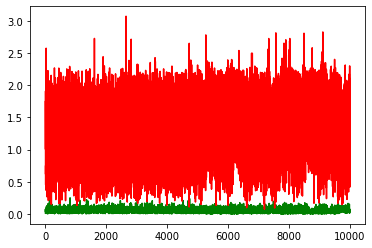

0.0013508815 0.25125766
0.07473159 3.0733552
Accuracy of adversial input with transformation:  0.11590000241994858
Accuracy of non-adversial input with transformation:  0.13079999387264252


In [13]:
vision_guard(X_test, X_adv, model,0.5, y_test)

Green color is KL div value for clean images and red color is KL div value on fgsm adversarial images